<center><font size="6">Fashion Mnist Project<font size="3"> <br>
Course : Deep Learning <br>
Papadopoulos Nikos

####Intro####

Fashion-MNIST is a dataset of Zalando’s article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. It is split in 10,000 as test and 50,000 as train datasets. Although the dataset is relatively simple, it can be used as the basis for learning and practicing how to develop, evaluate, and use deep convolutional neural networks for image classification from scratch.

####Library imports####

In [1]:
#Installs
!pip install -q -U keras-tuner
!pip install -q -U visualkeras

#Library installs
import keras
import random
import numpy as np
import visualkeras
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.metrics import f1_score,accuracy_score
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Dense, Activation,Dropout, Flatten,Conv2D, MaxPooling2D 

     |████████████████████████████████| 133 kB 14.3 MB/s 
     |████████████████████████████████| 992 kB 31.1 MB/s 


#### Functions ####

Creating specific functions to be used later on for visualization of the model results.

In [2]:
#Functions

# confusion matrix function
def plot_confusion_matrix(df_cm,name_plot):    
    index = df_cm.index
    index.name = "True Values"

    columns= df_cm.columns
    columns.name = "Predict"

    plt.figure(figsize = (15,10))

    # by default number in float .2 : fmt=.2g, but we want eg.789
    sns.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.1%',
               cmap=sns.color_palette("crest", as_cmap=True))

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.title(name_plot+': Confusion Matrix with percentage %')

    #Rotating axis labels
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.show()
# Lineplot function to check overfitting and accuracy 
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(14,10))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(test_images[indx].reshape(28,28), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(class_names[test_labels[indx]],class_names[hypermodel_pred_labels[indx]]),size=12)
    plt.show()    

#### Loading the Fashion-MNIST dataset ####

In [3]:
# Data  Loading
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
#Setting seed for reproducibility
random_seed = 20022
np.random.seed(random_seed)
set_seed = random_seed

In [5]:
# loading train and test data
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
#x_train,y_train,x_test,y_test

4431872/4422102 [==============================] - 0s 0us/step


####Exploring the Data####

First we are going to explore the dataset to check the data size, balance and print some images to check the fashion mnist observations.

In [6]:
print("Train data size is :",train_images.shape[0])
print("Test data size is :",test_images.shape[0])
print("Train images shape is :",train_images.shape)
print("Test images shape is :",test_images.shape)

Train data size is : 60000
Test data size is : 10000
Train images shape is : (60000, 28, 28)
Test images shape is : (10000, 28, 28)


In [7]:
# names the different classes according the fashion mnist documentation
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

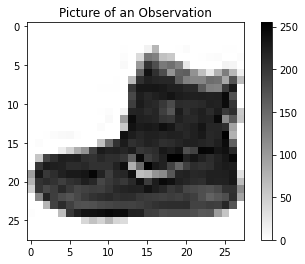

In [8]:
#Plotting an observation 
plt.figure()
plt.imshow(train_images[0],cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.title("Picture of an Observation")
plt.show()
# we can see the pizels more clear in this color scheme 

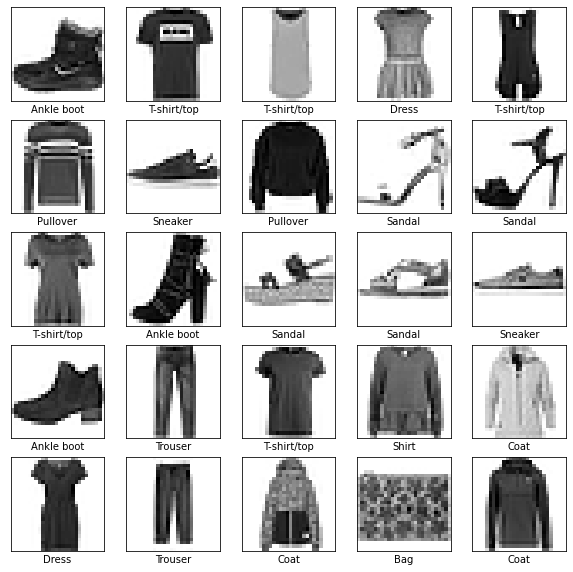

In [9]:
# ploting items of all classes
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

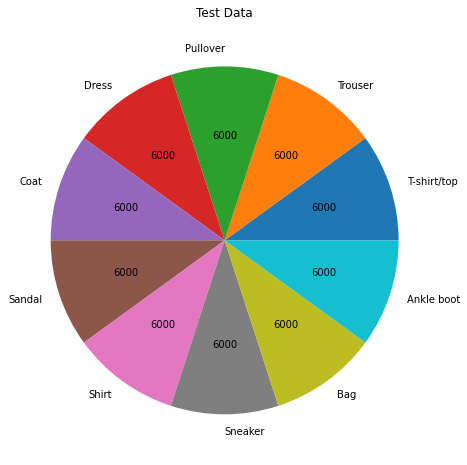

In [10]:
#Distribution of Train Data
counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,8))
plt.pie(x=counts[1],labels = class_names, autopct=lambda x: '{:.0f}'.format(x*counts[1].sum()/100) )
plt.title("Test Data")
plt.show()

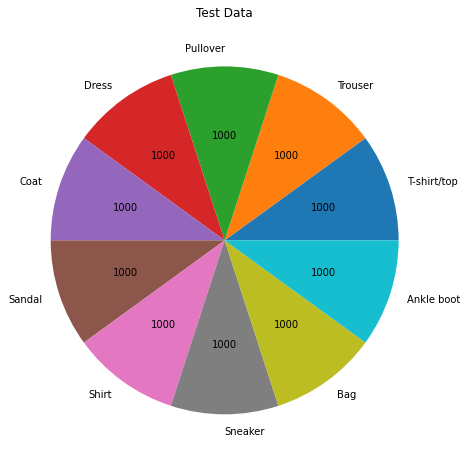

In [11]:
#Distribution of Test Data
counts = np.unique(test_labels, return_counts=True)
plt.rcParams["figure.figsize"] = (8,8)
plt.pie(x=counts[1],labels = class_names, autopct=lambda x: '{:.0f}'.format(x*counts[1].sum()/100) )
plt.title("Test Data")
plt.show()

#### Data Preprocessing ####

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. <br>
As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

In [12]:
#Normalizing pixel values
train_images  = train_images / 255.0
test_images = test_images / 255.0

In [13]:
# Reshaping the obs into 28x28 pictures
x_train = train_images.reshape(-1,28,28,1)
x_test = test_images.reshape(-1,28,28,1)

####MLP####

It is time to start implementig out MLP model first.
We are going to use a Sequential Tunable Model in Keras and we are going to tune the Hyperparameters using Keras tuner with Bayesian Optimization. <br>
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data.The other layers can be whatever we want.
- We are going to tune the number of hidden layers and their respective nodes
- We are also going tune the Dropout rates ( to avoid overfitting)
- Finaly we are going to tune the nodes of the last Dense layer before our final output layer which will consist of as many nodes as the number of different classes.
- The most important hyperparameter that need tuning is the learning rate 
- We also using a kernel initializer to statistically initialise the weights in the model. This will generate the weights and distribute them, it can be used as the starting weights. <br>
We are using the ReLu activation function in each layer except the final one. We are going to use Softmax activation  to get a probability distribution value for each class, that is also why we are using Sparse Cross Entropy as our loss.


In [14]:
# def mlp_model(hp):
#     """Creates a HyperModel instance (or callable that takes hyperparameters and returns a Model instance)."""
#     hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])

#     model = tf.keras.Sequential(
#         [
#             tf.keras.layers.Flatten(input_shape=(28, 28,1)),
#             tf.keras.layers.Dense(
#                 units=hp.Int("1l_units", min_value=256, max_value=512, step=32),
#                 kernel_initializer="glorot_uniform",
#                 activation="relu",
#             ),
#             tf.keras.layers.Dropout(
#                 rate=hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)
#             ),
#             tf.keras.layers.Dense(
#                 units=hp.Int("2l_units", min_value=256, max_value=512, step=32),
#                 kernel_initializer="glorot_uniform",
#                 activation="relu",
#             ),
#             tf.keras.layers.Dense(
#                 units=10,
#                 kernel_initializer="glorot_uniform",
#                 activation="softmax",
#             ),
#         ]
#     )

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=["accuracy"],
#     )

#     return model

In [15]:
 # Building the Model 
 def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28,1)))
    
    # Tune the number of hidden layers and units in each layer
    # Number of hidden layers: 1 - 3
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 1, 4)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=64, max_value=512, step=32),
                kernel_initializer="glorot_uniform",
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0.0, 0.5, step=0.1)))
    
    # Add output layer with units  equal to the number of classes
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from  0.001, or 0.0001.
    # We run the loop for a bigger range learning rate values but it was too time consuming
    # and we only kept the 2 best learning values for further development of our model.
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-4,1e-5])
    
    # Define optimizer, loss, and metrics 
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [16]:
# Instantiate the tunerKeras Tuner
#The Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model
#Hyperband tuning proved to be too time consuming and its results didn't yield better results that Bayesian optimization so we decided to use the last.
tuner = kt.BayesianOptimization( build_model,
                     objective="val_accuracy", #Metric which will be used for the hyperparameter tuning
                     max_trials=25,
                     beta = 3.5, # using the beta parameter whic is a balancing factor od exploration and exploitation (default value is 2.6)
                     seed=random_seed
                     )

In [17]:
#Overlook of the hyperparameter to be tuned. Some of the hyperparameters are not shown here because of the loop
tuner.search_space_summary()

Search space summary
Default search space size: 2
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05], 'ordered': True}


In [18]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8,restore_best_weights=True)

# #Tuning
tuner.search(x_train,train_labels,
             epochs=50,
             batch_size= 64,
             validation_split=0.2,
             callbacks=[stop_early],
             verbose=1)

Trial 25 Complete [00h 00m 56s]
val_accuracy: 0.8955833315849304

Best val_accuracy So Far: 0.903083324432373
Total elapsed time: 00h 51m 01s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0] # this used only the best set of hyperparameters as the list is ordered

In [20]:
# Overlook of the final model
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 512)               33280     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [23]:
# Building the final model using the aformentioned best set of hyperparameters
hypermodel = tuner.hypermodel.build(best_hps)

history = hypermodel.fit(x_train, train_labels, 
                         epochs=100, 
                         validation_split=0.2, 
                         batch_size= 256,
                         callbacks=[stop_early])

Epoch 1/100
188/188 [==============================] - 1s 5ms/step - loss: 1.3083 - accuracy: 0.5479 - val_loss: 0.6845 - val_accuracy: 0.7514
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 0.7143 - accuracy: 0.7486 - val_loss: 0.5291 - val_accuracy: 0.8132
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 0.5858 - accuracy: 0.7968 - val_loss: 0.4677 - val_accuracy: 0.8335
Epoch 4/100
188/188 [==============================] - 1s 4ms/step - loss: 0.5218 - accuracy: 0.8179 - val_loss: 0.4322 - val_accuracy: 0.8446
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 0.4836 - accuracy: 0.8315 - val_loss: 0.4120 - val_accuracy: 0.8535
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 0.4518 - accuracy: 0.8412 - val_loss: 0.3925 - val_accuracy: 0.8592
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 0.4317 - accuracy: 0.8488 - val_loss: 0.3814 - val_accuracy: 0.8650

After the training we are going to evaluate our model. The first thing that we want to check is the difference between the values of the accuracy, loss between the training and validation set, so we can predict early signs of overfitting before the visual evaluation.

In [24]:
eval_result = hypermodel.evaluate(x_test, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 2ms/step - loss: 0.3214 - accuracy: 0.8883
[test loss, test accuracy]: [0.3214187026023865, 0.8883000016212463]


Afterwards we are going to use our function to plot the loss,accuracy curves for both train and validation, to check the performance of our model and see any inisights about the overall function of the model.

Train Loss     : 0.19417
Validation Loss: 0.30166
Test Loss      : 0.32142
---
Train Accuracy     : 0.92862
Validation Accuracy: 0.89717
Test Accuracy      : 0.88830



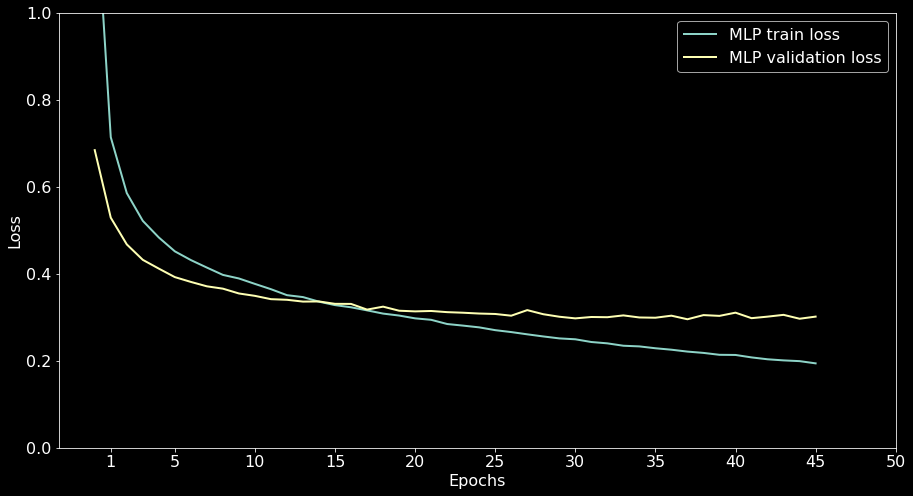

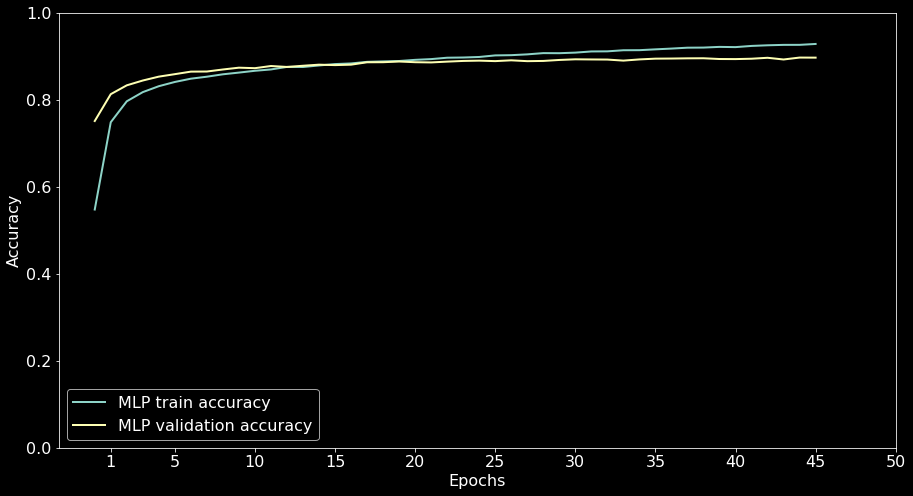

In [25]:
epochs = 50
print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': history}, epochs=epochs, metric='accuracy')

#### MLP Error Analysis####


After completing the tuning and training of our model we are going to use some metrics to evaluate our mistakes in order to try and imporve our model's performance. Of course we are going to plot some of the missclassified observations, because there may be some images that are trully difficult to classify.

In [26]:
# making the predictions and counting the total number of missclassified observations
hypermodel_pred_distribution = hypermodel.predict(x_test)
hypermodel_pred_labels = [np.argmax(p) for p in hypermodel_pred_distribution]
misclassified_indices = np.argwhere(test_labels != hypermodel_pred_labels)
print('Number of misclassified:', len(misclassified_indices))

Number of misclassified: 1117


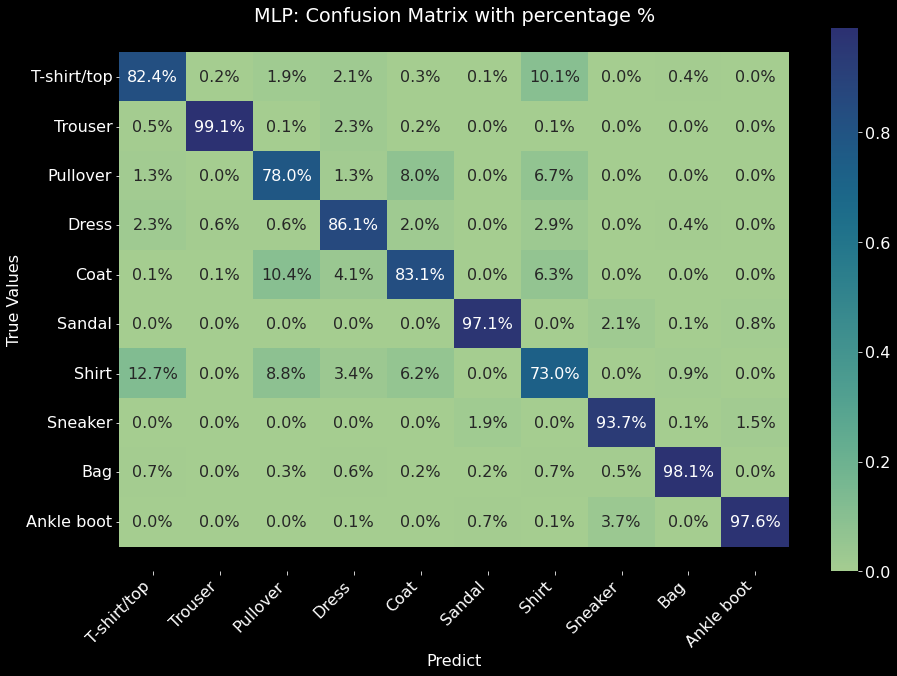

In [27]:
# plotting a confusion matrix to check the performance of our MLP in each class 
confusion_mlp = confusion_matrix(test_labels, hypermodel_pred_labels)
df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_names], columns = [i for i in class_names])
plot_confusion_matrix(df_cm_mlp,'MLP')

- As we can see from the confusion matrix the MLP performs best on the trouser category(99.1%). This makes perfect sense since there is only one class of the data with this kind of clothing.
- The shirt category as well as the coat, seem to be the most difficult to predict correctly. This also makes sense since the shirts and T-shirts classes have observations that look almost similar and even a human annotator could possibly confuse one with the other

In [ ]:
correct = np.nonzero(test_labels==hypermodel_pred_labels)[0]
incorrect = np.nonzero(test_labels!=hypermodel_pred_labels)[0]

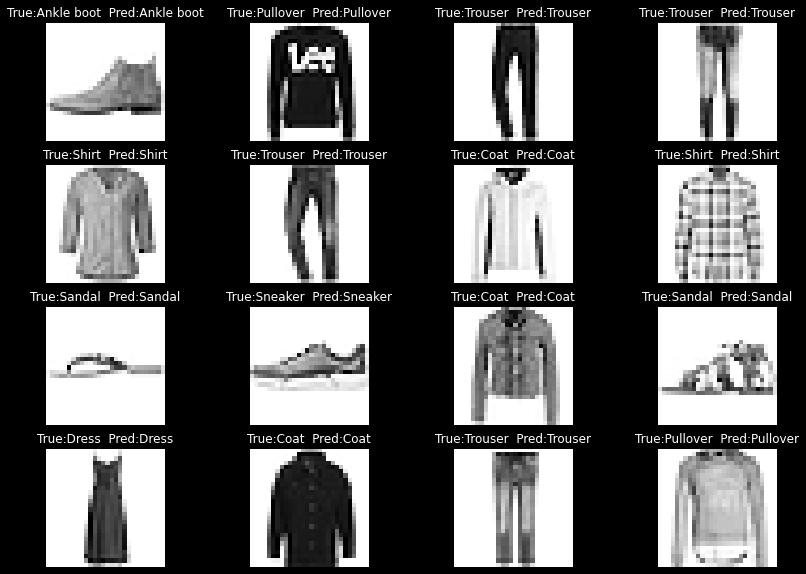

In [ ]:
plot_images(correct, "Greys")

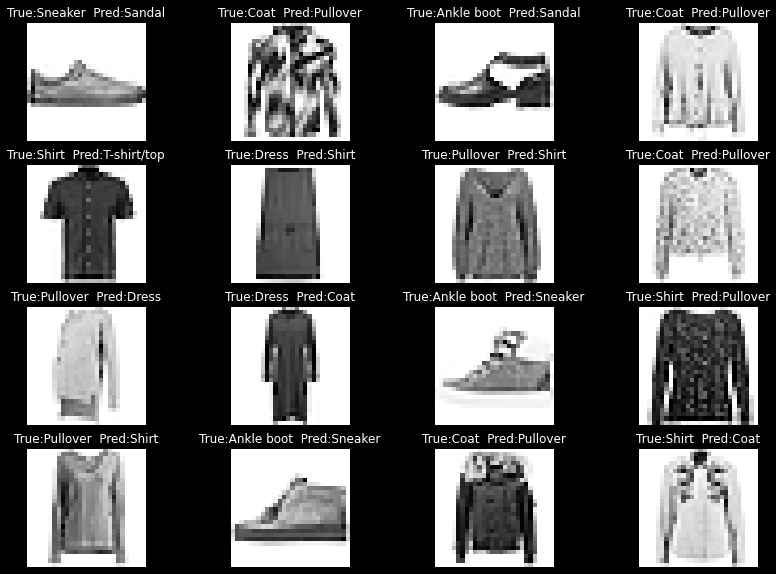

In [ ]:
plot_images(incorrect, "Greys")

####CNN####

 After completing our MLP model we are going to try a different approach. We are going to use a Convolutional Neural Network(CNN). CNNs are distinguished from other neural networks by their superior performance with image, speech, or audio signal inputs. They have three main types of layers :
 - Convolutional Layers
 - Pooling Layers
 - Fully connected layers <br>

It's main difference from an MLP is that a CNN takes a tensor as input instead of a vector. The CNN can understand spatial relations between pixels of images better thus making it better for image classification. <br>

**Building the CNN**

We are going to use a Sequential Tunable Model in Keras and we are going to tune the Hyperparameters using Keras tuner with Bayesian Optimization. <br>
- The first layer of our CNN is a data augmentation Layer consisting  of 3 augmentation techniques( Random Flip, Random Zoom)
- Our model consists of 4 convolutional layers, 2 of them followed by Max Pooling layers
- After the convolution level we are flattening the output so we pass it as input on our Dense Layers
- Finaly we are using 2 Dense layers
- There are also Batch Normalization and Dropout Layers in almost every level, because in a big Neural Network as this, overfitting is pretty usual<br>

We are using the ReLu activation function and padding(to maintain the size) in each layer except the final one. We are going to use Softmax activation  to get a probability distribution value for each class, and categorical cros entropy as our loss.


In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(28,
                                  28,
                                  1)),
    
    #layers.RandomRotation(0.10),
    layers.RandomZoom(0.2),
  ]
)

In [ ]:
train_labels = to_categorical(train_labels,num_classes = 10)
test_labels = to_categorical(test_labels,num_classes = 10)

In [ ]:
# building the CNN
def cnn_model2(hp):
  model= Sequential()

  #
  model.add(data_augmentation)
  
  model.add(keras.layers.Convolution2D(filters=hp.Int("filter1",min_value=32,max_value=128,step=32),kernel_size=(4,4),input_shape=(28, 28, 1),padding="same",activation="relu"))
  model.add(keras.layers.BatchNormalization())
  #
  model.add(keras.layers.Convolution2D(filters=hp.Int("filter2",min_value=32,max_value=128,step=32),kernel_size=(4,4),padding="same",activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(rate=hp.Float("dropout1",0.15,0.45,step=0.15)))
  #
  model.add(keras.layers.Convolution2D(filters=hp.Int("filter3",min_value=32,max_value=128,step=32),kernel_size=(4,4),padding="same",activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(rate=hp.Float("dropout2",0.15,0.45,step=0.15)))
  #
  model.add(keras.layers.Convolution2D(filters=hp.Int("filter4",min_value=32,max_value=128,step=32),kernel_size=(4,4),padding="same",activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Dropout(rate=hp.Float("dropout3",0.15,0.45,step=0.15)))
  #
  model.add(keras.layers.Flatten())
  #
  model.add(keras.layers.Dense(units=hp.Int("dense1",min_value=32,max_value=256,step=32),activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(rate=hp.Float("dropout4",0.15,0.45,step=0.15)))
  #
  model.add(keras.layers.Dense(units=hp.Int("dense2",min_value=32,max_value=64,step=16),activation="relu"))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(rate=hp.Float("dropout5",0.15,0.45,step=0.15)))
  #
  model.add(keras.layers.Dense(10,activation="softmax"))
  #
  hp_learning_rate = hp.Choice("learning_rate", values=[0.0005,0.001,0.00146])  # learning rates from site that show the best results for Adam optimizer


  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),metrics=["accuracy"])
  return model

In [ ]:
tuner = kt.BayesianOptimization(
    cnn_model2,
    objective="val_accuracy",
    max_trials= 20,
    beta = 3
)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

In [ ]:
tuner.search(
    x_train,
    train_labels,
    epochs=15,
    validation_split=0.2,
    batch_size=256,
    callbacks=[stop_early]
    )

Trial 20 Complete [00h 04m 23s]
val_accuracy: 0.9304999709129333

Best val_accuracy So Far: 0.9329166412353516
Total elapsed time: 01h 18m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        544       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       65664     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=300, validation_split=0.2,batch_size=256,callbacks=[stop_early])

Epoch 1/300
188/188 [==============================] - 16s 77ms/step - loss: 0.5676 - accuracy: 0.7995 - val_loss: 2.5828 - val_accuracy: 0.2023
Epoch 2/300
188/188 [==============================] - 15s 78ms/step - loss: 0.3636 - accuracy: 0.8681 - val_loss: 1.3451 - val_accuracy: 0.6265
Epoch 3/300
188/188 [==============================] - 15s 78ms/step - loss: 0.3224 - accuracy: 0.8825 - val_loss: 0.4151 - val_accuracy: 0.8495
Epoch 4/300
188/188 [==============================] - 14s 76ms/step - loss: 0.2924 - accuracy: 0.8923 - val_loss: 0.3532 - val_accuracy: 0.8742
Epoch 5/300
188/188 [==============================] - 15s 80ms/step - loss: 0.2709 - accuracy: 0.9012 - val_loss: 0.2662 - val_accuracy: 0.9046
Epoch 6/300
188/188 [==============================] - 14s 76ms/step - loss: 0.2561 - accuracy: 0.9068 - val_loss: 0.2995 - val_accuracy: 0.8875
Epoch 7/300
188/188 [==============================] - 14s 77ms/step - loss: 0.2473 - accuracy: 0.9103 - val_loss: 0.2191 - val_ac

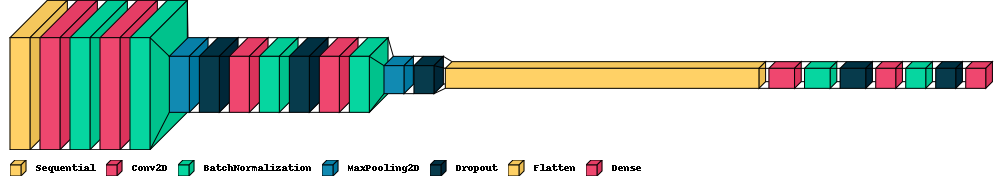

In [ ]:
#Visual representation of the architecture of the CNN
visualkeras.layered_view(model,legend=True)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# Saving the model in order to keep the optimal hyperparameters
# model.save('/content/DeepModelFashionMnist')
#from keras.models import load_model
#ourmodel = tf.keras.models.load_model('/content/DeepModelFashionMnist')

In [ ]:
eval_result = model.evaluate(test_images, test_labels, verbose=3)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.18645615875720978, 0.9391999840736389]


In [ ]:
pred = model.predict(x_test)
print("Prediction is -> {}".format(pred[12]))
print("Actual value is -> {}".format(test_labels[12]))
print("The highest value for label is {}".format(np.argmax(pred[12])))

Prediction is -> [4.2076408e-08 1.7061339e-07 1.3778540e-06 5.5440740e-08 1.1611754e-07
 7.7779923e-06 2.9208753e-08 9.9994409e-01 7.9333324e-07 4.5572811e-05]
Actual value is -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The highest value for label is 7


Train Loss     : 0.11456
Validation Loss: 0.17624
Test Loss      : 0.18646
---
Train Accuracy     : 0.95760
Validation Accuracy: 0.94233
Test Accuracy      : 0.93920



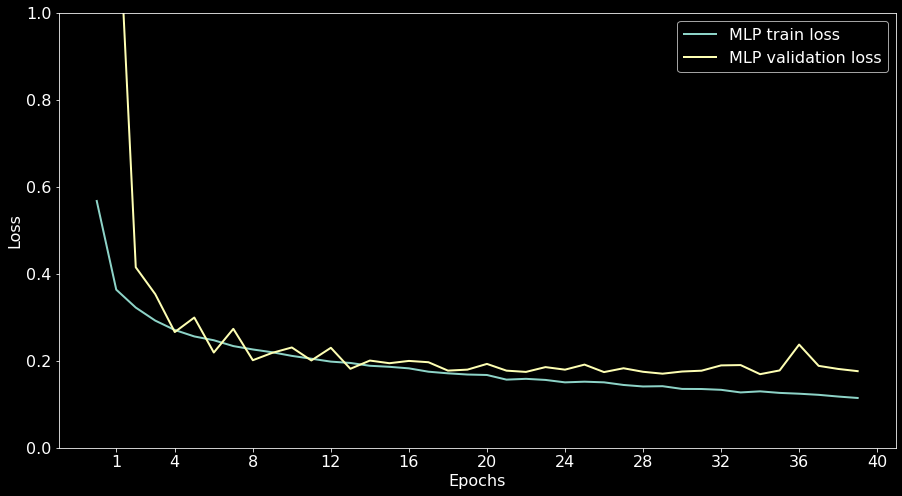

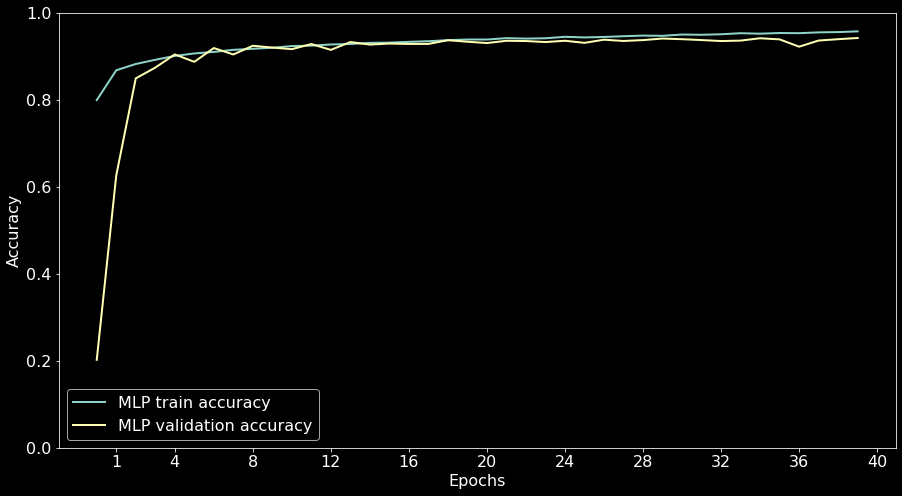

In [ ]:
epochs = len(history.history['val_loss'])

print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'MLP': history}, epochs=epochs, metric='loss')
plot_history(hs={'MLP': history}, epochs=epochs, metric='accuracy')


ERROR ANALYSIS

In [ ]:
test_labels = [np.argmax(p) for p in test_labels]

In [ ]:
hypermodel_pred_distribution = model.predict(x_test)
hypermodel_pred_labels = [np.argmax(p) for p in hypermodel_pred_distribution]

In [ ]:
# misclassified_indices = np.argwhere(test_labels != hypermodel_pred_labels)
# print('Number of misclassified:', len(misclassified_indices))

In [ ]:
# countring the missclassified observations in the CNN
count=0
y=0
for i in range(len(test_labels)):
  if test_labels[i]!=hypermodel_pred_labels[i]:
    count+=1
print('Number of misclassified:',count)

Number of misclassified: 608


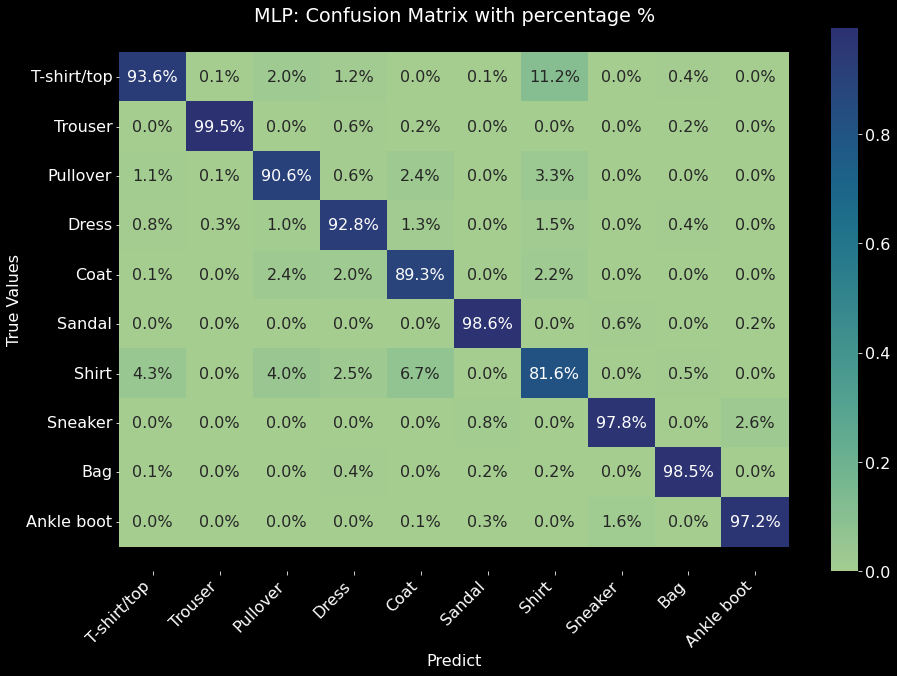

In [ ]:
# Confusion Matrix of the CNN
confusion_mlp = confusion_matrix(test_labels, hypermodel_pred_labels)
df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_names], columns = [i for i in class_names])
plot_confusion_matrix(df_cm_mlp,'MLP')

- As we can see from the confusion matrix the CNN outperforms our MLP and the best classification is on the trouser category(99.5%). This makes perfect sense since there is only one class of the data with this kind of clothing.
- The shirt category as well as the coat, seem to be the most difficult to predict correctly. This also makes sense since the shirts and T-shirts classes have observations that look almost similar and even a human annotator could possibly confuse one with the other.<br>

Although in general the most missclassified observations come from the same 2 categories in both models, CNN does a better job classifing overall. THe result is as expected since we already knew that CNNs are optimal for image classification in comparison of the two.

#### Final Insights ####

After completing this project, we adapted many of the theoretical aspects of the course, into our model implementations. Also our knowledge of the setbacks and the way to overcome them was significantly aided by the course material.<br>

As a final proposal to maybe improve even slightly our overall score: 
- We could use a pretrained model( which is not feaseble due to the lack of resources)
- We could suggest a gridsearch tuning ( which is an exhaustive search, hence making it too time consuming)
- We could incorporate momentum into our optimizer to aid it in finding the   global minima, overcoming the setback of minimal changes over epochs
 
